# Using EvalML to Predict Housing Prices

<p align="center">
<img width=50% src="https://evalml-web-images.s3.amazonaws.com/evalml_horizontal.svg" alt="Featuretools" />
</p>

## Problem and Dataset

The  [Predict Housing Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) dataset on Kaggle is a supervised regression task for which the objective is to predict the sale price of a house based on a series of attributes about the property.

In this tutorial, we use  [EvalML](https://github.com/alteryx/evalml) to preprocess the data as well as define customized pipelines by providing a range of hyperparameters that we want AutoML to iterate over when looking for the pipeline that performs the best at estimating the sale price of a house.

## Approach 

We will show how  [EvalML](https://github.com/alteryx/evalml) can be leveraged to perform preprocessing, feature selection, hyperparameter specification, pipeline creation, and automated machine learning. While EvalML allows for plenty of options for customization to improve prediction outcomes, we'll focus on a fairly high-level implementation.

Our approach will be as follows:

1. Read in the data and analyze it.
2. Understand the data through visualization.
3. Perform basic preprocessing.
4. Provide a hyperparameter range for our custom pipelines.
4. Search for a best performing pipeline based on our objective.
5. Review the best pipeline chosen and analyze its performance.

First we're going to need to import some libraries.

In [1]:
import evalml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from evalml.data_checks import HighlyNullDataCheck, IDColumnsDataCheck

## Dataset 

The Housing Prices dataset consists of 1,000+ instances and 80+ features alongside a label - `SalePrice`. Since this is a high dimensional dataset, we'll want to do a significant amount of feature analysis.

In [2]:
data_original = pd.read_csv('./data/train.csv')
data_original.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

One of the incredibly useful set of tools that EvalML provides are called `DataChecks`. These `DataChecks` do exactly what they're named after, they check the input data for common pitfalls and errors we find in machine learning. Everything from data leakage to excessive correlation and more can be checked for and then corrected by the user.

Right now we're going to check out two of these `DataChecks`:

- `IDColumnsDataCheck` - Check if any of the features are likely to be ID columns
- `HighlyNullDataCheck` - Check if there are any highly-null columns in the input data

In [3]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
X = data_original.copy()
y = X.pop('SalePrice')
ic_ = IDColumnsDataCheck()
dc_ = HighlyNullDataCheck(pct_null_col_threshold=0.2, pct_null_row_threshold=0.2)

The `Id` column was quickly identified by the data check and will definitely be dropped. From what we can see, there are a few columns that have a relatively high number of null values which we can do without. Additionally, the `MiscVal` feature, despite having no null values, is an extension of the `MiscFeature` which is highly null.

In [5]:
display(ic_.validate(X, y))
display(dc_.validate(X, y))

{'warnings': [{'message': "Columns 'Id' are 100.0% or more likely to be an ID column",
   'data_check_name': 'IDColumnsDataCheck',
   'level': 'warning',
   'details': {'columns': ['Id'], 'rows': None},
   'code': 'HAS_ID_COLUMN'}],
 'errors': [],
 'actions': [{'code': 'DROP_COL',
   'data_check_name': 'IDColumnsDataCheck',
   'metadata': {'columns': ['Id'], 'rows': None}}]}

{'warnings': [{'message': "Columns 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature' are 20.0% or more null",
   'data_check_name': 'HighlyNullDataCheck',
   'level': 'warning',
   'details': {'columns': ['Alley',
     'FireplaceQu',
     'PoolQC',
     'Fence',
     'MiscFeature'],
    'rows': None,
    'pct_null_rows': {'Alley': 0.9376712328767123,
     'FireplaceQu': 0.4726027397260274,
     'PoolQC': 0.9952054794520548,
     'Fence': 0.8075342465753425,
     'MiscFeature': 0.963013698630137}},
   'code': 'HIGHLY_NULL_COLS'}],
 'errors': [],
 'actions': [{'code': 'DROP_COL',
   'data_check_name': 'HighlyNullDataCheck',
   'metadata': {'columns': ['Alley',
     'FireplaceQu',
     'PoolQC',
     'Fence',
     'MiscFeature'],
    'rows': None}}]}

Another feature to examine is `LotFrontage` which provides the linear feet of street connected to a property. We have over 200 null values for this feature, most likely to represent properties that have no exposure to a street (strange, I know) or values too low to be included. Instead of keeping these entries as null, we're going to replace them with 0.

In [6]:
X = X.drop(['Id', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'], axis=1)
X.loc[X['LotFrontage'].isna(), 'LotFrontage'] = 0

## Visualization

A useful way to understand this high dimensional data is by visualizing the relationship that certain features have with each other. Some of these features pertain to the same aspect of a property and should be fairly correlated.

For example, we wouldn't expect any of our data to have a value for `YearBuilt` that is greater than `YearRemodAdd` since a property couldn't have been remodelled before the date it was built. We would also expect to see a positive correlation between `1stFlrSF` and `2ndFlrSF`.

We'll also graph some of the more intuitively important features against the label `SalePrice` to see if they actually hold any predictive power.

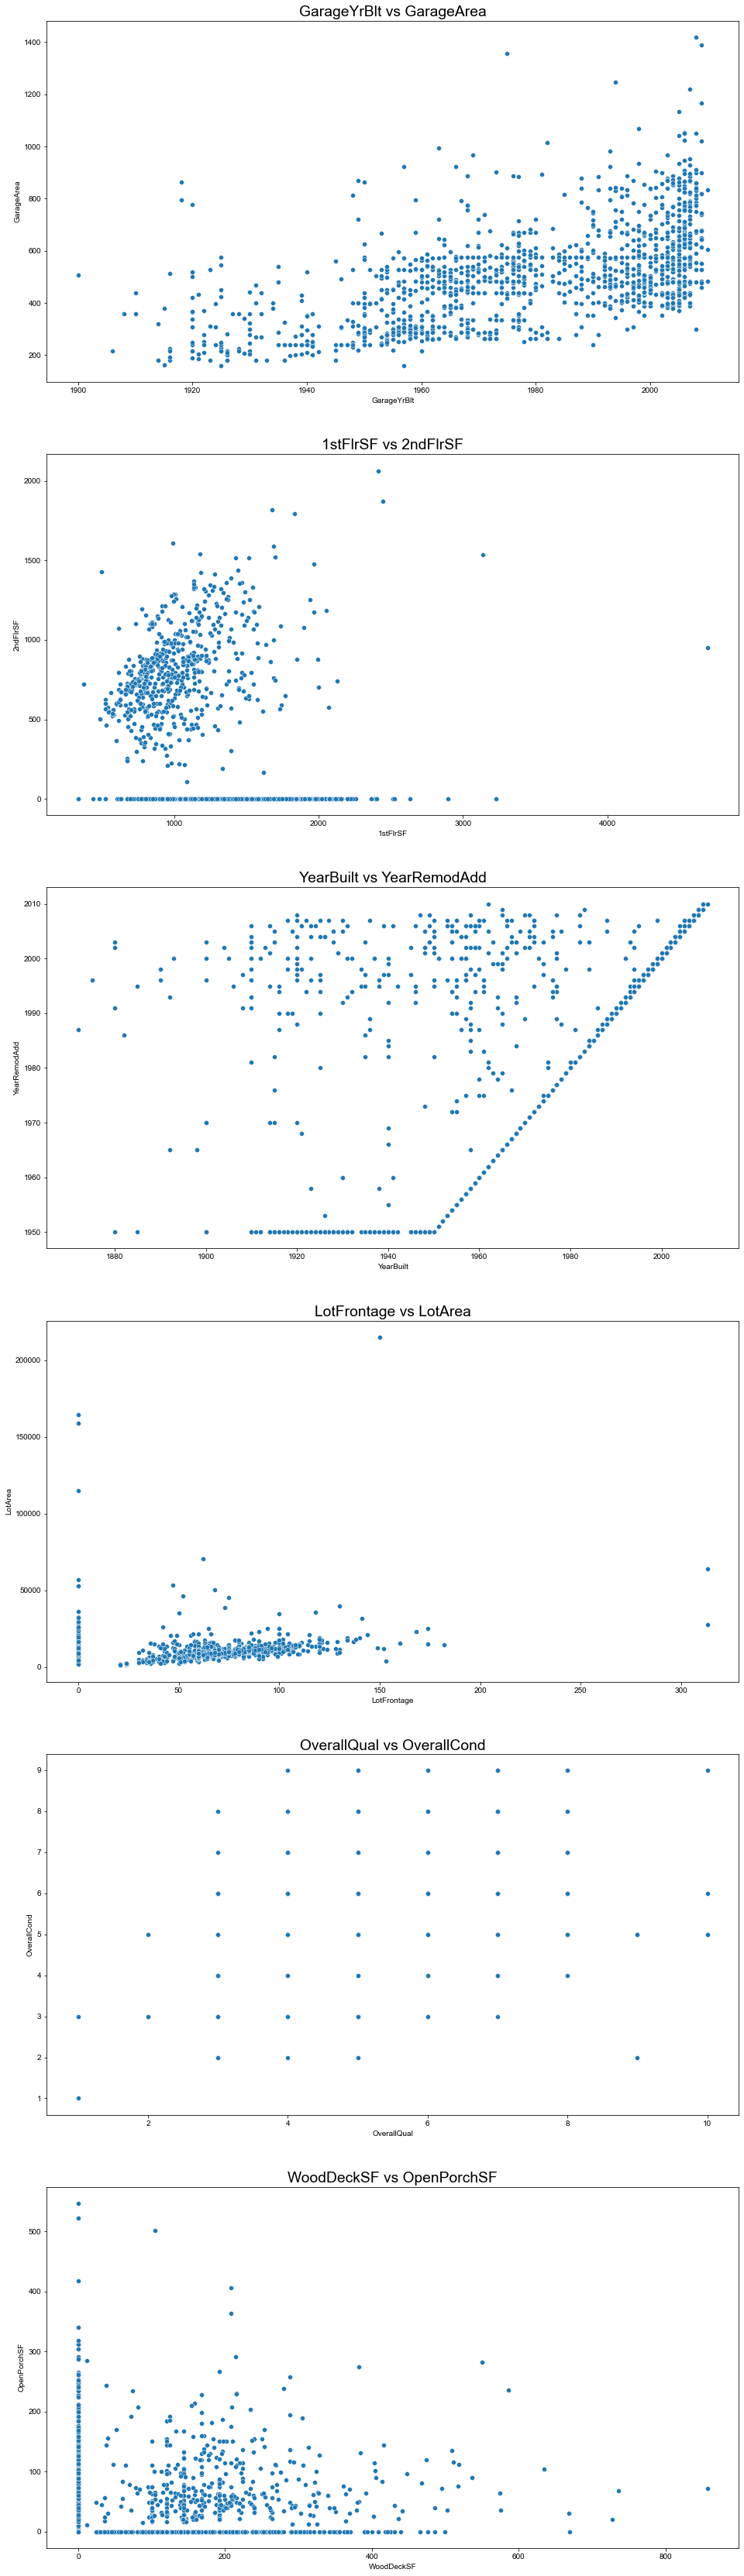

In [7]:
feature_pairs = [['GarageYrBlt', 'GarageArea'],
                 ['1stFlrSF', '2ndFlrSF'],
                 ['YearBuilt', 'YearRemodAdd'],
                 ['LotFrontage', 'LotArea'],
                 ['OverallQual', 'OverallCond'],
                 ['WoodDeckSF', 'OpenPorchSF']]

fig, ax = plt.subplots(nrows=len(feature_pairs), ncols=1, figsize=(16, 10*len(feature_pairs)))
sns.set(font_scale=1.6)

for ind, feature_pair in enumerate(feature_pairs):
    sns.scatterplot(x=feature_pair[0], y=feature_pair[1], data=X, ax=ax[ind])
    ax[ind].set_title(f"{feature_pair[0]} vs {feature_pair[1]}")

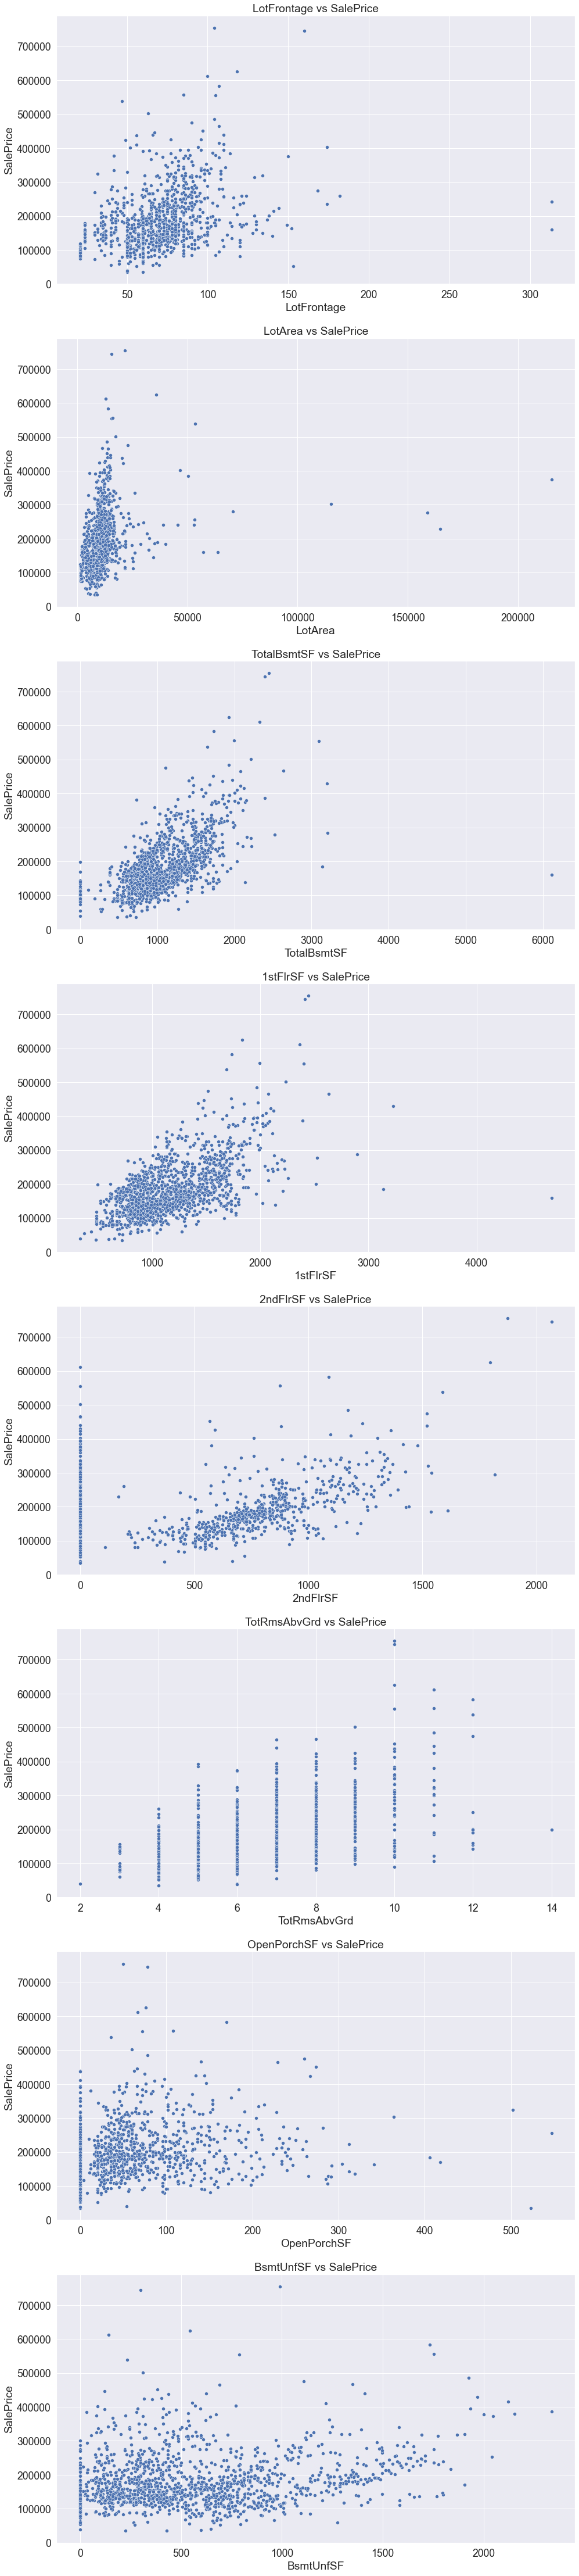

In [8]:
cols_ = ["LotFrontage", "LotArea", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "TotRmsAbvGrd", "OpenPorchSF", "BsmtUnfSF"]

fig, ax = plt.subplots(nrows=len(cols_), ncols=1, figsize=(16, 10*len(cols_)))
sns.set(font_scale=1.6)

for ind, col_ in enumerate(cols_):
    sns.scatterplot(x=col_, y='SalePrice', data=data_original, ax=ax[ind])
    ax[ind].set_title(f"{col_} vs SalePrice")

After going through some visualizations of the data and using some intuition, we can bring down the total features that we want to use to the following 28 (plus the label). After dropping any stray null observations, we're ready for preprocessing.

In [9]:
cols_ = ["MSSubClass", "MSZoning", "LotFrontage", "LotArea", "OverallQual", "OverallCond", "YearBuilt", "YearRemodAdd",
         "MasVnrArea", "ExterQual", "ExterCond", "BsmtQual", "BsmtExposure", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", 
         "TotalBsmtSF", "HeatingQC", "1stFlrSF", "2ndFlrSF", "GrLivArea", "FullBath", "KitchenQual", "TotRmsAbvGrd", 
         "GarageYrBlt", "GarageArea", "WoodDeckSF", "OpenPorchSF"]
X = X[cols_]

In [10]:
data = X.copy()
data['SalePrice'] = y
data.dropna(inplace=True)
data = data.reset_index(drop=True)
data

MSSubClass MSZoning  LotFrontage  LotArea  OverallQual  OverallCond  \
0             60       RL         65.0     8450            7            5   
1             20       RL         80.0     9600            6            8   
2             60       RL         68.0    11250            7            5   
3             70       RL         60.0     9550            7            5   
4             60       RL         84.0    14260            8            5   
...          ...      ...          ...      ...          ...          ...   
1335          60       RL         62.0     7917            6            5   
1336          20       RL         85.0    13175            6            6   
1337          70       RL         66.0     9042            7            9   
1338          20       RL         68.0     9717            5            6   
1339          20       RL         75.0     9937            5            6   

      YearBuilt  YearRemodAdd  MasVnrArea ExterQual  ... 2ndFlrSF GrLivArea  \
0          2003          2003       196.0        Gd  ...      854      1710   
1          1976          1976         0.0        TA  ...        0      1262   
2          2001          2002       162.0        Gd  ...      866      1786   
3          1915          1970         0.0        TA  ...      756      1717   
4          2000          2000       350.0        Gd  ...     1053      2198   
...         ...           ...         ...       ...  ...      ...       ...   
1335       1999          2000         0.0        TA  ...      694      1647   
1336       1978          1988       119.0        TA  ...        0      2073   
1337       1941          2006         0.0        Ex  ...     1152      2340   
1338       1950          1996         0.0        TA  ...        0      1078   
1339       1965          1965         0.0        Gd  ...        0      1256   

     FullBath  KitchenQual  TotRmsAbvGrd  GarageYrBlt  GarageArea WoodDeckSF  \
0           2           Gd             8       2003.0         548          0   
1           2           TA             6       1976.0         460        298   
2           2           Gd             6       2001.0         608          0   
3           1           Gd             7       1998.0         642          0   
4           2           Gd             9       2000.0         836        192   
...       ...          ...           ...          ...         ...        ...   
1335        2           TA             7       1999.0         460          0   
1336        2           TA             7       1978.0         500        349   
1337        2           Gd             9       1941.0         252          0   
1338        1           Gd             5       1950.0         240        366   
1339        1           TA             6       1965.0         276        736   

      OpenPorchSF  SalePrice  
0              61     208500  
1               0     181500  
2              42     223500  
3              35     140000  
4              84     250000  
...           ...        ...  
1335           40     175000  
1336            0     210000  
1337           60     266500  
1338            0     142125  
1339           68     147500  

[1340 rows x 29 columns]

## Preprocessing the Data

Some of the features that we've chosen as part of our dataset have ordinal categories, which means that one-hot encoding would result in a loss of explainability. Since these categories are naturally ordered, we will have to convert these into numeric form for our machine learning later on.

According to the dataset description (which can be found as an attachment when downloading the dataset), the column values are represented as such:
- `Po` - Poor
- `Fa` - Fair
- `TA` - Typical/Average
- `Gd` - Good
- `Ex` - Excellent

In [11]:
columns_to_encode = ['ExterQual', 'ExterCond', 'BsmtQual', 'HeatingQC', 'KitchenQual']
for column in columns_to_encode:
    data[column] = data[column].replace({'Po': 0,
                                         'Fa': 1,
                                         'TA': 2,
                                         'Gd': 3,
                                         'Ex': 4})
data['BsmtExposure'] = data['BsmtExposure'].replace({'No': 0,
                                                     'Mn': 1,
                                                     'Av': 2,
                                                     'Gd': 3})

In [12]:
X = data.copy()
y = X.pop('SalePrice')

EvalML provides a set of data checks with a single function call (`DefaultDataChecks`) that looks for commonly identified issues in machine learning. For a regression problem, these are the data checks we'll be running immediately:
- `HighlyNullDataCheck` - Check if there are any highly-null columns in the input data
- `IDColumnsDataCheck` - Check if any of the features are likely to be ID columns
- `TargetLeakageDataCheck` - Check if any of the features are highly correlated with the target
- `InvalidTargetDataCheck` - Check if the target data contains missing or invalid values
- `NoVarianceDataCheck` - Check if the target or any of the features have no variance
- `DateTimeNaNDataCheck` - Check if NaN values are present in any datetime features
- `NaturalLanguageNaNDataCheck` - Check if NaN values are present in any natural language features

Additionally, we'll want to check for two more:
- `MulticollinearityDataCheck` - Check if any features are likely to be multicollinear
- `OutliersDataCheck` - Check if there are any outliers in the input data

In [13]:
from evalml.data_checks import DefaultDataChecks, MulticollinearityDataCheck, OutliersDataCheck
dc_ = DefaultDataChecks(problem_type="regression", objective="R2")
mc_ = MulticollinearityDataCheck()
oc_ = OutliersDataCheck()

In [14]:
results = dc_.validate(X, y)
mc_results = mc_.validate(X, y)
oc_results = oc_.validate(X, y)
print(f"Default Data Checks")
pprint(results)
print(f"Multicollinearity Data Checks")
pprint(mc_results)
print(f"Outliers Data Checks")
pprint(oc_results)

Default Data Checks
{'actions': [{'code': 'TRANSFORM_TARGET',
              'data_check_name': 'TargetDistributionDataCheck',
              'metadata': {'columns': None,
                           'is_target': True,
                           'rows': None,
                           'transformation_strategy': 'lognormal'}}],
 'errors': [],
 'warnings': [{'code': 'TARGET_LOGNORMAL_DISTRIBUTION',
               'data_check_name': 'TargetDistributionDataCheck',
               'details': {'columns': None,
                           'normalization_method': 'shapiro',
                           'p-value': 0.0,
                           'rows': None,
                           'statistic': 0.9},
               'level': 'warning',
               'message': 'Target may have a lognormal distribution.'}]}
Multicollinearity Data Checks
{'actions': [], 'errors': [], 'warnings': []}
Outliers Data Checks
{'actions': [{'code': 'DROP_ROWS',
              'data_check_name': 'OutliersDataCheck',
       

                                    454,
                                    455,
                                    456,
                                    457,
                                    459,
                                    460,
                                    462,
                                    463,
                                    464,
                                    468,
                                    470,
                                    472,
                                    473,
                                    475,
                                    477,
                                    479,
                                    481,
                                    482,
                                    483,
                                    486,
                                    488,
                                    492,
                                    493,
                                    494,
                

Thanks to the `DataChecks` we ran earlier, `HighlyNullDataCheck` and `IDColumnsDataCheck` didn't result in any warnings. While most of the data checks passed without a problem, the check for outliers raised some warnings regarding some of our features. Based on a quick visualization of a few of these, we can verify that there are definitely some outliers. The next step is to provide a cutoff and bring these outliers to a value that's more appropriate to the rest of the data.

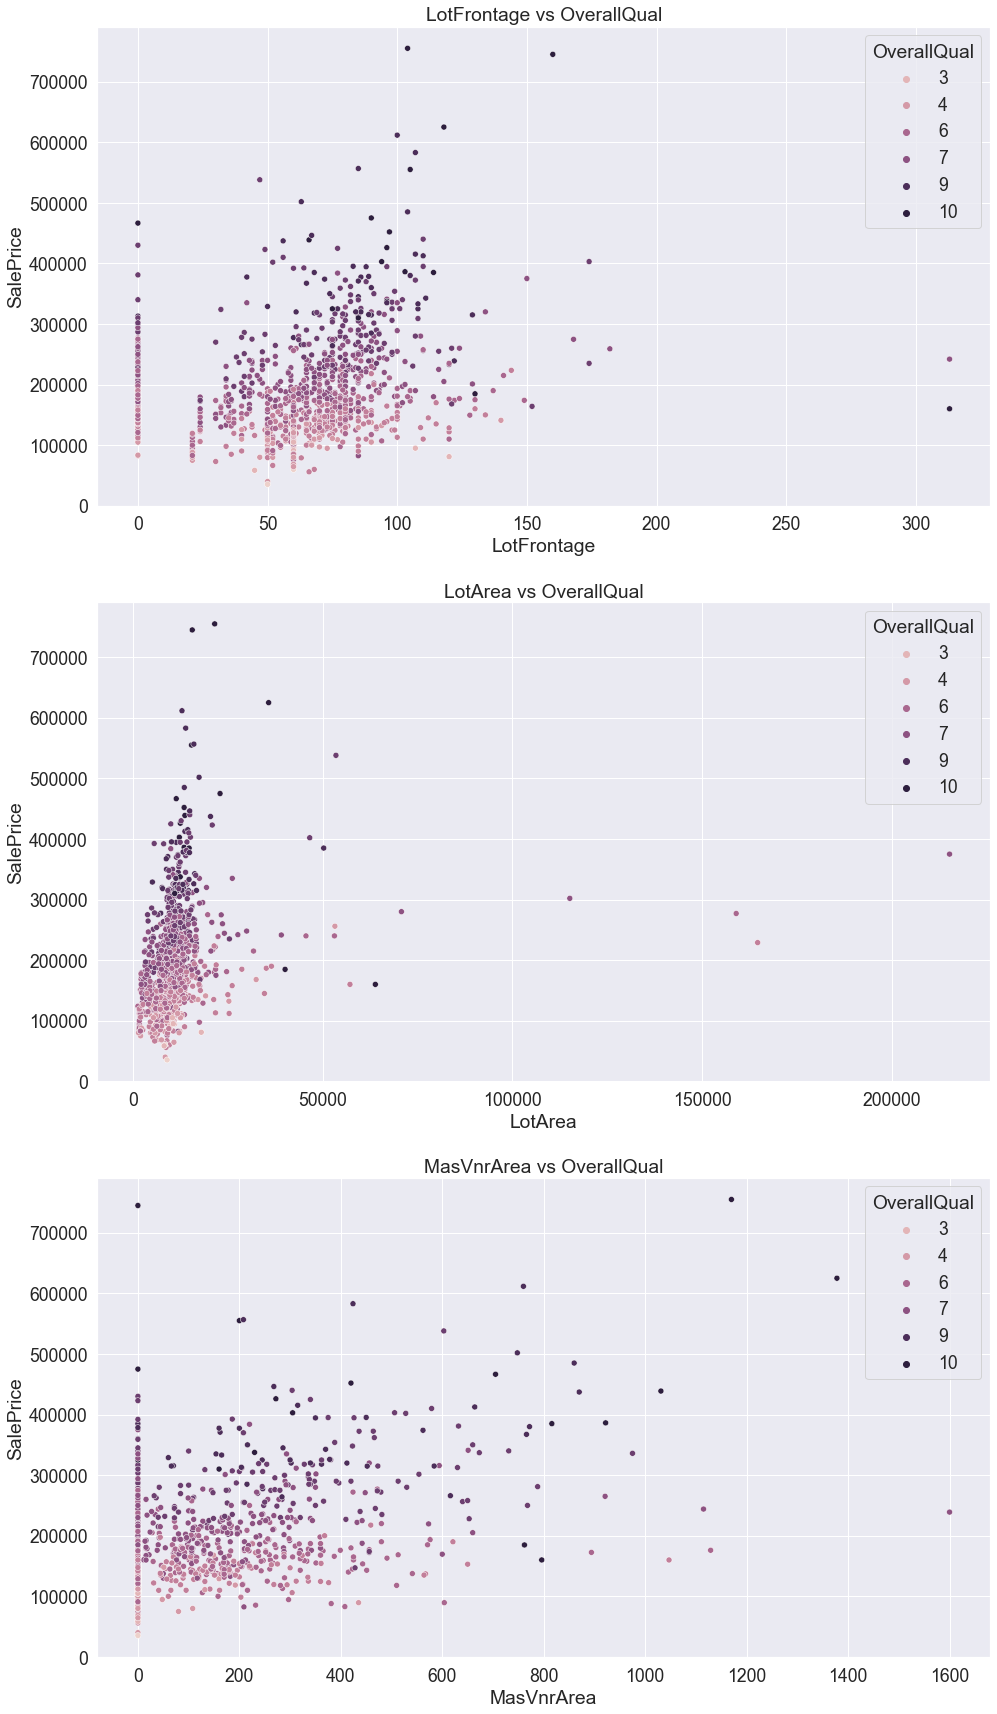

In [15]:
cols_ = ["LotFrontage", "LotArea", "MasVnrArea"]

fig, ax = plt.subplots(nrows=len(cols_), ncols=1, figsize=(16, 10*len(cols_)))
sns.set(font_scale=1.6)

for ind, col_ in enumerate(cols_):
    sns.scatterplot(x=col_, y=y, hue='OverallQual', data=X, ax=ax[ind])
    ax[ind].set_title(f"{col_} vs OverallQual")

In [16]:
display(X.loc[X['LotFrontage']>200, X.columns])
display(X.loc[X['LotArea']>60000, X.columns])
display(X.loc[X['MasVnrArea']>1200, X.columns])
display(X.loc[X['BsmtFinSF1']>2000, X.columns])
display(X.loc[X['BsmtFinSF2']>1200, X.columns])
display(X.loc[X['BsmtUnfSF']>2000, X.columns])
display(X.loc[X['TotalBsmtSF']>3000, X.columns])
display(X.loc[X['GrLivArea']>3500, X.columns])

X.loc[X['LotFrontage']>200, "LotFrontage"] = 200
X.loc[X['LotArea']>30000, "LotArea"] = 30000
X.loc[X['MasVnrArea']>1200, "MasVnrArea"] = 1200
X.loc[X['BsmtFinSF1']>2000, "BsmtFinSF1"] = 2000
X.loc[X['BsmtFinSF2']>1200, "BsmtFinSF2"] = 1200
X.loc[X['BsmtUnfSF']>2000, "BsmtUnfSF"] = 2000
X.loc[X['TotalBsmtSF']>3000, "TotalBsmtSF"] = 3000
X.loc[X['GrLivArea']>3500, "GrLivArea"] = 3500

MSSubClass MSZoning  LotFrontage  LotArea  OverallQual  OverallCond  \
862           20       RL        313.0    27650            7            7   
1189          60       RL        313.0    63887           10            5   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ...  1stFlrSF  2ndFlrSF  \
862        1960          2007         0.0          2  ...      2069         0   
1189       2008          2008       796.0          4  ...      4692       950   

      GrLivArea  FullBath  KitchenQual  TotRmsAbvGrd  GarageYrBlt  GarageArea  \
862        2069         2            3             9       1960.0         505   
1189       5642         2            4            12       2008.0        1418   

      WoodDeckSF  OpenPorchSF  
862            0            0  
1189         214          292  

[2 rows x 28 columns]

MSSubClass MSZoning  LotFrontage  LotArea  OverallQual  OverallCond  \
226           50       RL          0.0   159000            6            7   
285           20       RL        150.0   215245            7            5   
307          190       RL          0.0   164660            5            6   
413           20       RL         62.0    70761            7            5   
647           20       RL          0.0   115149            7            5   
1189          60       RL        313.0    63887           10            5   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ...  1stFlrSF  2ndFlrSF  \
226        1958          2006       472.0          3  ...      1444       700   
285        1965          1965         0.0          2  ...      2036         0   
307        1965          1965         0.0          2  ...      1619       167   
413        1975          1975         0.0          2  ...      1533         0   
647        1971          2002       351.0          2  ...      1824         0   
1189       2008          2008       796.0          4  ...      4692       950   

      GrLivArea  FullBath  KitchenQual  TotRmsAbvGrd  GarageYrBlt  GarageArea  \
226        2144         2            3             7       1958.0         389   
285        2036         2            2             8       1965.0         513   
307        1786         2            2             7       1965.0         529   
413        1533         2            3             5       1975.0         576   
647        1824         2            3             5       1971.0         739   
1189       5642         2            4            12       2008.0        1418   

      WoodDeckSF  OpenPorchSF  
226            0           98  
285            0            0  
307          670            0  
413          200           54  
647          380           48  
1189         214          292  

[6 rows x 28 columns]

MSSubClass MSZoning  LotFrontage  LotArea  OverallQual  OverallCond  \
270           60       FV         66.0     7399            7            5   
1071          60       RL        118.0    35760           10            5   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ...  1stFlrSF  2ndFlrSF  \
270        1997          1998      1600.0          3  ...       975       975   
1071       1995          1996      1378.0          3  ...      1831      1796   

      GrLivArea  FullBath  KitchenQual  TotRmsAbvGrd  GarageYrBlt  GarageArea  \
270        1950         2            3             7       1997.0         576   
1071       3627         3            3            10       1995.0         807   

      WoodDeckSF  OpenPorchSF  
270            0           10  
1071         361           76  

[2 rows x 28 columns]

MSSubClass MSZoning  LotFrontage  LotArea  OverallQual  OverallCond  \
482           60       RL        130.0    40094           10            5   
827           20       RL        100.0    12919            9            5   
1082          60       RL        160.0    15623           10            5   
1189          60       RL        313.0    63887           10            5   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ...  1stFlrSF  2ndFlrSF  \
482        2007          2008       762.0          4  ...      3138      1538   
827        2009          2010       760.0          4  ...      2364         0   
1082       1996          1996         0.0          3  ...      2411      2065   
1189       2008          2008       796.0          4  ...      4692       950   

      GrLivArea  FullBath  KitchenQual  TotRmsAbvGrd  GarageYrBlt  GarageArea  \
482        4676         3            4            11       2007.0         884   
827        2364         2            4            11       2009.0         820   
1082       4476         3            4            10       1996.0         813   
1189       5642         2            4            12       2008.0        1418   

      WoodDeckSF  OpenPorchSF  
482          208          406  
827            0           67  
1082         171           78  
1189         214          292  

[4 rows x 28 columns]

MSSubClass MSZoning  LotFrontage  LotArea  OverallQual  OverallCond  \
294          60       RL         86.0    10380            7            5   

     YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ...  1stFlrSF  2ndFlrSF  \
294       1986          1987       172.0          3  ...      1553      1177   

     GrLivArea  FullBath  KitchenQual  TotRmsAbvGrd  GarageYrBlt  GarageArea  \
294       2730         2            3             8       1987.0         576   

     WoodDeckSF  OpenPorchSF  
294         201           96  

[1 rows x 28 columns]

MSSubClass MSZoning  LotFrontage  LotArea  OverallQual  OverallCond  \
203           20       RL        103.0    13472           10            5   
253           20       RL        107.0    14450            9            5   
438           60       RL        105.0    13693            9            5   
533           20       RL         98.0    12704            8            5   
620           20       RL         80.0    11844            8            5   
1160          20       RL         89.0    13214            9            5   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ...  1stFlrSF  2ndFlrSF  \
203        2003          2003       922.0          4  ...      2392         0   
253        2006          2007       315.0          4  ...      2121         0   
438        2006          2006       772.0          4  ...      2069       574   
533        2008          2009       306.0          4  ...      2042         0   
620        2008          2008       464.0          3  ...      2046         0   
1160       2008          2009         0.0          4  ...      2018         0   

      GrLivArea  FullBath  KitchenQual  TotRmsAbvGrd  GarageYrBlt  GarageArea  \
203        2392         2            4             8       2003.0         968   
253        2121         2            4             8       2007.0         732   
438        2643         2            4             9       2006.0         694   
533        2042         2            4             8       2009.0        1390   
620        2046         2            3             7       2008.0         834   
1160       2018         2            4            10       2009.0         746   

      WoodDeckSF  OpenPorchSF  
203          248          105  
253          124           98  
438          414           84  
533            0           90  
620          322           82  
1160         144           76  

[6 rows x 28 columns]

MSSubClass MSZoning  LotFrontage  LotArea  OverallQual  OverallCond  \
304           20       RL         85.0    10655            8            5   
403           20       RL        105.0    15431           10            5   
456           20       RL          0.0    12692            8            5   
482           60       RL        130.0    40094           10            5   
1189          60       RL        313.0    63887           10            5   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ...  1stFlrSF  2ndFlrSF  \
304        2003          2004       296.0          3  ...      1629         0   
403        2008          2008       200.0          4  ...      2402         0   
456        1992          1993         0.0          3  ...      3228         0   
482        2007          2008       762.0          4  ...      3138      1538   
1189       2008          2008       796.0          4  ...      4692       950   

      GrLivArea  FullBath  KitchenQual  TotRmsAbvGrd  GarageYrBlt  GarageArea  \
304        1629         2            3             7       2003.0         880   
403        2402         2            4            10       2008.0         672   
456        3228         3            3            10       1992.0         546   
482        4676         3            4            11       2007.0         884   
1189       5642         2            4            12       2008.0        1418   

      WoodDeckSF  OpenPorchSF  
304            0            0  
403            0           72  
456          264           75  
482          208          406  
1189         214          292  

[5 rows x 28 columns]

MSSubClass MSZoning  LotFrontage  LotArea  OverallQual  OverallCond  \
166           75       RM         90.0    22950           10            9   
482           60       RL        130.0    40094           10            5   
633           60       RL        104.0    21535           10            6   
1071          60       RL        118.0    35760           10            5   
1082          60       RL        160.0    15623           10            5   
1189          60       RL        313.0    63887           10            5   

      YearBuilt  YearRemodAdd  MasVnrArea  ExterQual  ...  1stFlrSF  2ndFlrSF  \
166        1892          1993         0.0          3  ...      1518      1518   
482        2007          2008       762.0          4  ...      3138      1538   
633        1994          1995      1170.0          4  ...      2444      1872   
1071       1995          1996      1378.0          3  ...      1831      1796   
1082       1996          1996         0.0          3  ...      2411      2065   
1189       2008          2008       796.0          4  ...      4692       950   

      GrLivArea  FullBath  KitchenQual  TotRmsAbvGrd  GarageYrBlt  GarageArea  \
166        3608         2            4            12       1993.0         840   
482        4676         3            4            11       2007.0         884   
633        4316         3            4            10       1994.0         832   
1071       3627         3            3            10       1995.0         807   
1082       4476         3            4            10       1996.0         813   
1189       5642         2            4            12       2008.0        1418   

      WoodDeckSF  OpenPorchSF  
166            0          260  
482          208          406  
633          382           50  
1071         361           76  
1082         171           78  
1189         214          292  

[6 rows x 28 columns]

We can revisualize some of these features again to make sure they look more appropriate.

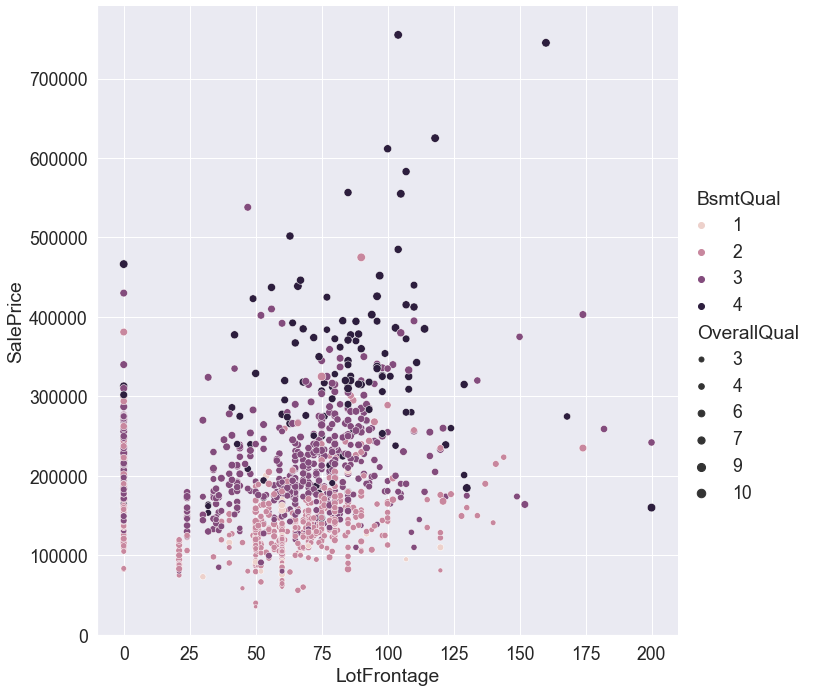

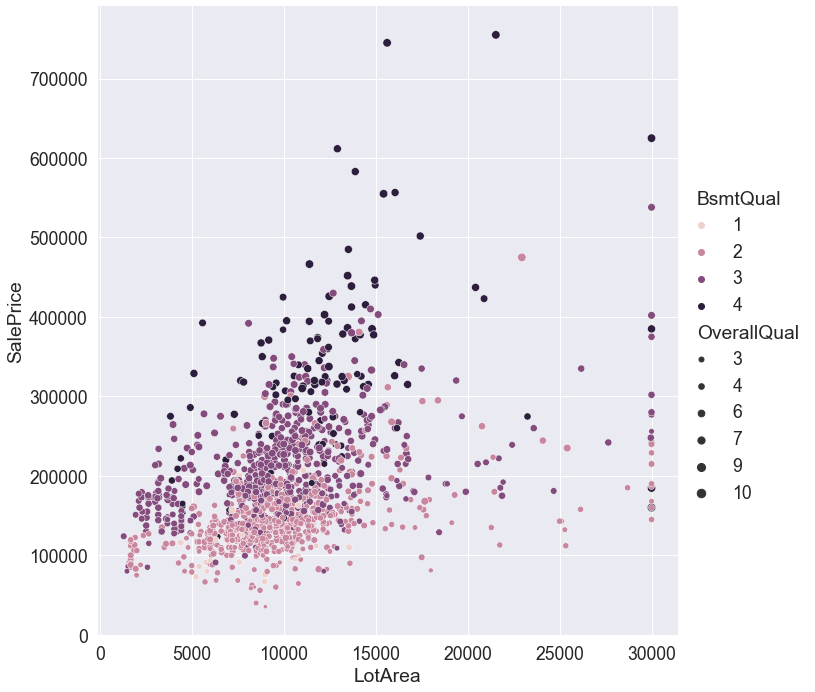

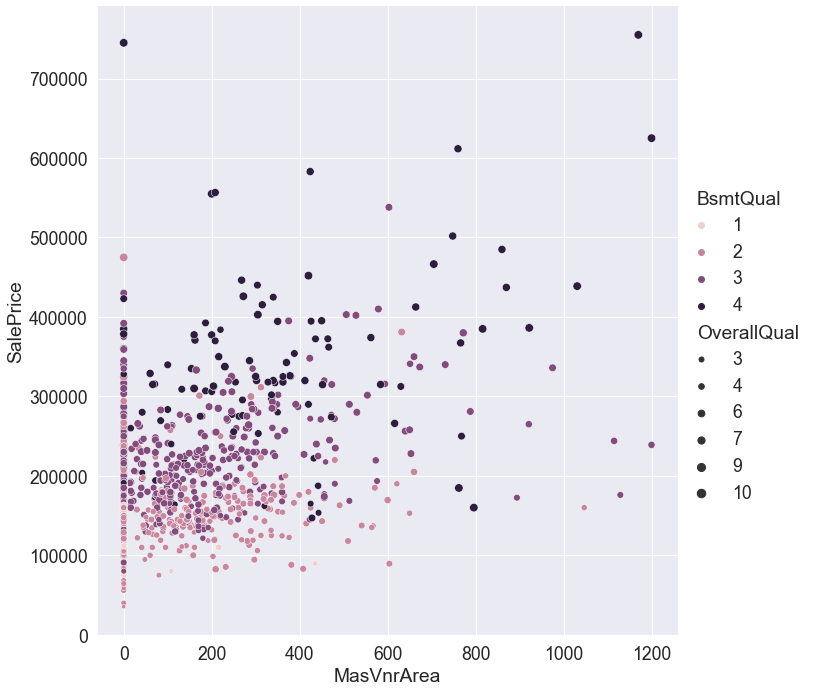

In [17]:
cols_ = ["LotFrontage", "LotArea", "MasVnrArea"]

sns.set(font_scale=1.6)

for ind, col_ in enumerate(cols_):
    sns.relplot(x=col_, y=y, hue='BsmtQual', size='OverallQual', data=X, height=10)

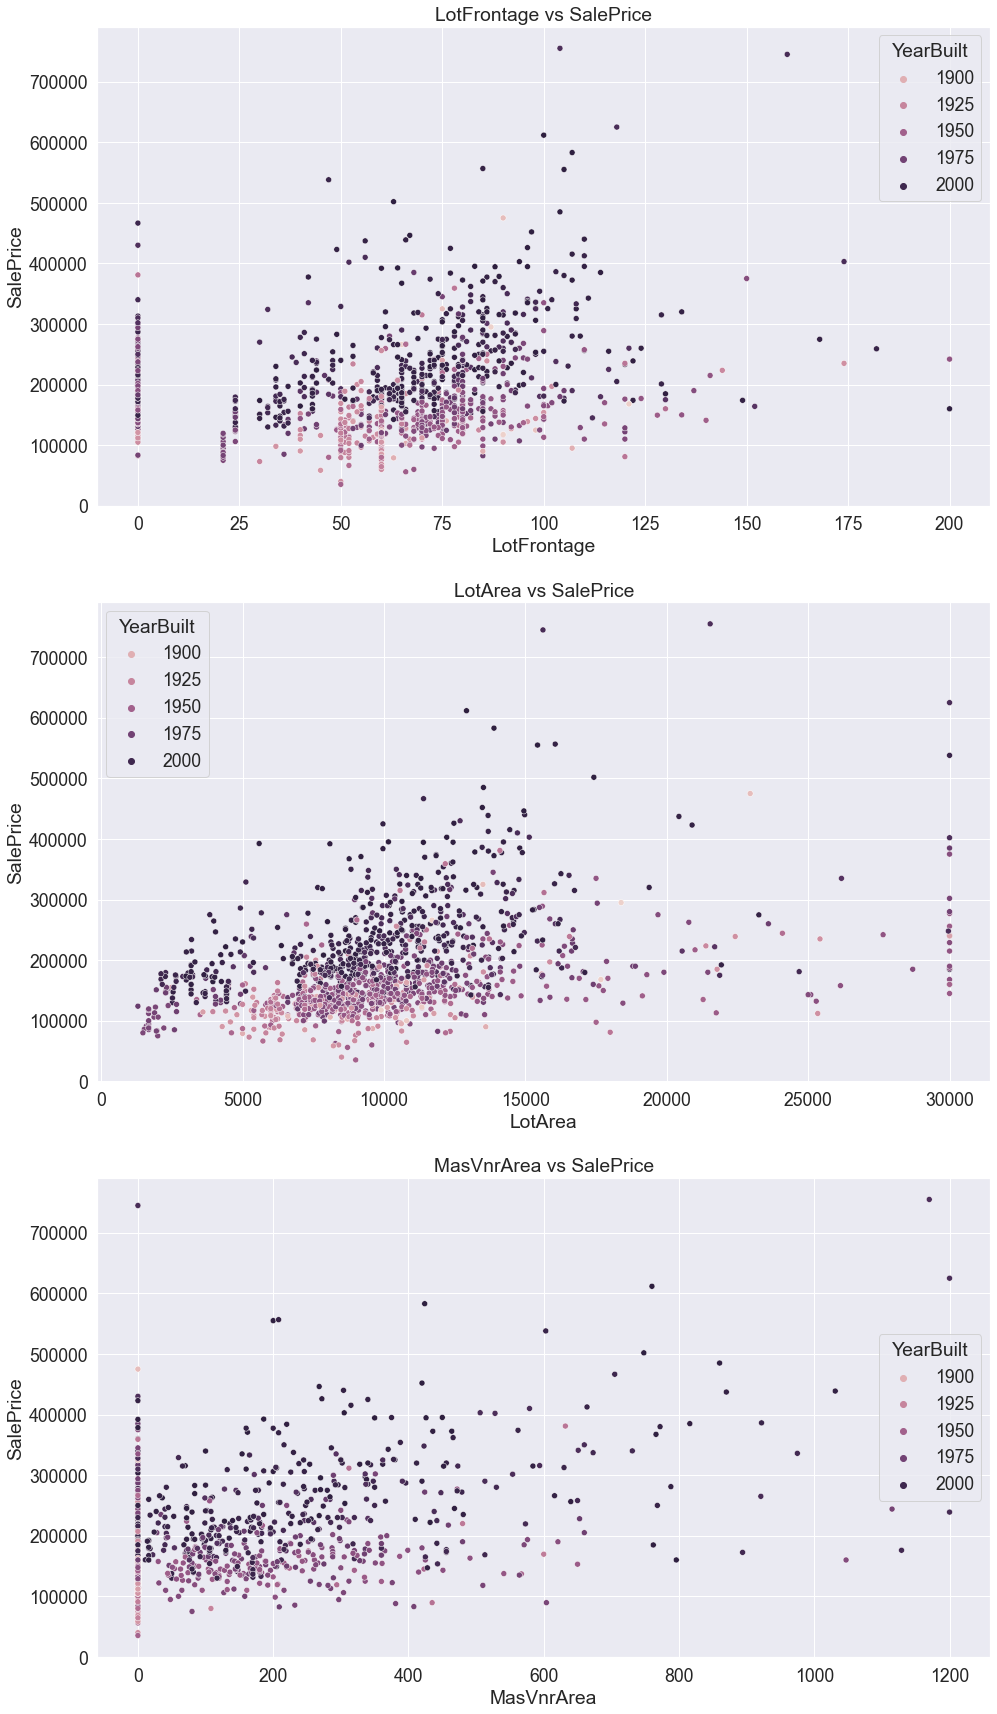

In [18]:
cols_ = ["LotFrontage", "LotArea", "MasVnrArea"]

fig, ax = plt.subplots(nrows=len(cols_), ncols=1, figsize=(16, 10*len(cols_)))
sns.set(font_scale=1.6)

for ind, col_ in enumerate(cols_):
    sns.scatterplot(x=col_, y=y, hue='YearBuilt', data=X, ax=ax[ind])
    ax[ind].set_title(f"{col_} vs SalePrice")

## Hyperparameters through Custom Parameters

Before we perform the actual machine learning, there's another feature provided by EvalML that we can explore. Although we will rely on the automated machine learning we'll be leveraging later to provide us with generated pipelines, we can specify pipeline structures and hyperparameter ranges ahead of time that we would like `AutoML` to search over. In this fairly high level implementation, we're going to specify the hyperparameter ranges for the estimators that we'll be including in the `AutoMLSearch` and create a set of pipelines that we'll want to include them in.

After we've specified that, we can add a couple of things to our pipelines. We'll want to one hot encode the nominal categorical features and use a random forest regressor to select the best ones. The reason we want to use this selector is because we're still dealing with a relatively large number of features considering the size of our dataset. Luckily, EvalML provides a straightforward implementation to deal with this.

In [19]:
from skopt.space import Integer, Real

hyperparameters = {
    'Random Forest Regressor': {
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(5, 35)
    },
    'XGBoost Regressor': {
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(5, 19)
    },
    'LightGBM Regressor': {
        'n_estimators': Integer(10, 80),
        'max_depth': Integer(0, 8),
    },
    'Extra Trees Regressor': {
        'n_estimators': Integer(100, 300),
        'max_depth': Integer(5, 15)
    },
    'CatBoost Regressor': {
        'n_estimators': Integer(10, 80),
        'max_depth': Integer(4, 8)
    },
    'Linear Regressor': {}
}

In [20]:
from evalml.pipelines.regression_pipeline import RegressionPipeline
graphs = {}
# all_pipelines = []
for estimator_ in hyperparameters.keys():
    component_graph = ['One Hot Encoder', 'RF Regressor Select From Model', estimator_]
    graphs[estimator_] = component_graph
#     parameters = {'RF Regressor Select From Model': {'number_features': 28,
#                                                      'percent_features': 0.6}}
#     all_pipelines.append(RegressionPipeline(component_graph=component_graph,
#                                             parameters=parameters))

## AutoML Search with Custom Pipelines

Now that all the preprocessing has been completed and our hyperparameters have been specified for our custom pipelines, we're ready to run our automated machine learning search for the best pipeline. First we'll separate our data into training and test sets.

There's a few other parameters that we want to specify before we run `AutoMLSearch`. The first is to set the problem type, followed by the objective we're going to be optimizing for. After that we get to specify the pipelines that we want included in our search.

In [21]:
from evalml import AutoMLSearch

X_train, X_test, y_train, y_test = evalml.preprocessing.split_data(X, y, problem_type='regression',
                                                                         test_size=.25)

automl = AutoMLSearch(X_train=X_train, y_train=y_train, problem_type="regression", objective="Root Mean Squared Error",
                      allowed_component_graphs=graphs, custom_hyperparameters=hyperparameters, max_batches=10)
automl.search()

## Understanding Outcomes

After the `AutoMLSearch` is complete and we've identified the best pipeline that wes generated based on the parameters we passed in, we can understand the outcome of the process using some of EvalML's other tools.

The first thing we're going to do is take a brief look at some of the other pipelines that were generated during the automated machine learning process. We're also going to pick out the best performing pipeline, visualize it, and train it on the training data. It's important to remember that `AutoMLSearch` will identify the best pipeline for us, but the returned pipeline is untrained and can be used however we want.

In [22]:
for each in automl.full_rankings[:5].parameters:
    pprint(each)

{'Extra Trees Regressor': {'max_depth': 10,
                           'max_features': 'sqrt',
                           'min_samples_split': 2,
                           'min_weight_fraction_leaf': 0.0,
                           'n_estimators': 274,
                           'n_jobs': -1},
 'One Hot Encoder': {'categories': None,
                     'drop': 'if_binary',
                     'features_to_encode': None,
                     'handle_missing': 'error',
                     'handle_unknown': 'ignore',
                     'top_n': 10},
 'RF Regressor Select From Model': {'max_depth': None,
                                    'n_estimators': 10,
                                    'n_jobs': -1,
                                    'number_features': 28,
                                    'percent_features': 0.4828884661481364,
                                    'threshold': 'median'}}
{'Extra Trees Regressor': {'max_depth': 13,
                           'max_features

In [23]:
best_pipeline = automl.best_pipeline

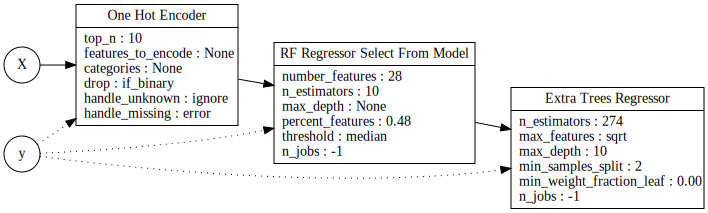

In [24]:
best_pipeline.graph()

In [25]:
best_pipeline.score(X_test, y_test, objectives=['Root Mean Squared Error'])

OrderedDict([('Root Mean Squared Error', 22012.459410192707)])

We'll also visualize the ranked importance of the features we used as well as compare our predicted and actual results on the testing labels.

In [26]:
from evalml.model_understanding.graphs import graph_permutation_importance, graph_prediction_vs_actual

graph_permutation_importance(best_pipeline, X_test, y_test, "R2")

In [27]:
predictions = best_pipeline.predict(X_test)
graph_prediction_vs_actual(y_test, predictions)

In [28]:
from evalml.objectives.standard_metrics import RootMeanSquaredLogError

rmsle = RootMeanSquaredLogError()
print(f"Root Mean Squared Log Error: {rmsle.score(y_true=y_test, y_predicted=predictions)}")

Root Mean Squared Log Error: 0.12669328173038066


## Key Points and Takeaways

To summarize, here's what we did:

1. First, we loaded in the data and understood more about it. Through `DataChecks` and visualizations, we were able to better grasp the data's features as well as what we were interested in keeping and what we weren't.
2. After that we performed preprocessing on the data, converted categorical variables to numeric, as well as brought in outliers that would have otherwise skewed our model's learning.
3. Before our `AutoMLSearch` could take place, we specified hyperparameter ranges for our estimators and create a graph of what components we wanted included in our pipelines.
4. And finally, we ran our search for the best pipeline. After we found it, we used some model understanding tools to better appreciate the outcome of the automated machine learning process.

In the end, we were able to preprocess our data and create customized pipelines for it that resulted in a Root Mean Squared Log Error score of under 0.12 with minimal work, which ranks in almost the [top 6%](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard) of Kaggle score submissions! With some feature engineering and a little more hyperparameter tuning, anything is possible!